Plots for the supplement, showing all the y-averaged data on separate axes.

Using `chan6` data.

Continuing `p2021-0629a_channel_width-deprot_plots.ipynb`.


## Setup

In [1]:
import os
import os.path as osp

In [2]:
import operator
import itertools

In [3]:
from datetime import datetime

In [4]:
import numpy as np

In [5]:
import pandas as pd

In [6]:
from scipy.integrate import trapz

In [7]:
import matplotlib.pyplot as plt

In [8]:
%matplotlib inline

In [9]:
import matplotlib as mpl

In [10]:
# from mpl_toolkits.axisartist.parasite_axes import HostAxes, ParasiteAxes

In [11]:
import matplotlib.ticker as plticker

In [12]:
from matplotlib.gridspec import GridSpec

In [13]:
#Uncomment for print
mpl.rcParams['figure.dpi']= 300

In [14]:
#Uncomment for presentation
# mpl.rcParams['xtick.labelsize']="xx-large"
# mpl.rcParams['ytick.labelsize']="xx-large"

In [15]:
##from matplotlib.gridspec import GridSpec #Not used at present but potentially useful

In [16]:
from matplotlib.colors import BoundaryNorm

In [17]:
import simproc

In [18]:
import simproc.requesthandler.yaml_manager as yaml_manager
import simproc.requesthandler.pickle_manager as pickle_manager
import simproc.requesthandler.locators as locators

## Constants

In [19]:
# taglist=['12A','16A','20A','27pct','50pct','na_27pct']
taglist=['12A','16A','20A','27pct','50pct']

In [20]:
dlocal_comp_list=["xx","yy","zz","avg"]

In [21]:
dlocal_fname_tmpl="D{comp}_{tag}_nd.csv"

In [22]:
pmf_fname_tmpl="pmf_{tag}_nd.csv"

In [23]:
wdens_fname_tmpl="density_Xplane_{mtag}.pkl"

In [24]:
bbox_fname_tmpl="bbox_{tag}.csv"

In [25]:
SELTOL=1e-6

In [26]:
width_tags=["12A","16A","20A"]
deprot_tags=["20A","27pct","50pct"]

In [27]:
#based on https://matplotlib.org/stable/gallery/color/color_cycle_default.html
prop_cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [28]:
tag_colors={tag:prop_cycle_colors[idx+3] for idx,tag in enumerate(taglist)}
tag_colors

{'12A': '#d62728',
 '16A': '#9467bd',
 '20A': '#8c564b',
 '27pct': '#e377c2',
 '50pct': '#7f7f7f'}

In [29]:
#For print
# font_settings={
#   "cbar_wdens": 16,
#   "cbar_dratio": 32,
#   "cbar_pmf": 16,
#   "axlabels": 12,
#   "axtitle": 14,
# }
#Intermediate
# font_settings={
#   "cbar_wdens": 20,
#   "cbar_dratio": 40,
#   "cbar_pmf": 20,
#   "axlabels": 16,
#   "axtitle": 18,
# }
#For presentation
# font_settings={
#   "cbar_wdens": 24,
#   "cbar_dratio": 40,
#   "cbar_pmf": 24,
#   "axlabels": 24,
#   "axtitle": 24,
# }

In [30]:
#Potential A values
#These were calculated in a spreadsheet, see log 2021-05-12.md
#In brief, they come from the B value and maximum value of 20 kT
A_values={
  "12A":61.111,
  "16A":34.375,
  "20A":22
}

In [31]:
#Potential B value, the same in all cases
B_value=-2

In [32]:
#beta, 1 because potentials are in kT
beta = 1.0

## Data folder

In [33]:
datadir=osp.abspath("../chan6")
assert osp.isdir(datadir)

In [34]:
o=locators.SetDataFolder(datafolder=datadir)

## Locators

In [35]:
#locators.folder_structure.keys()

In [36]:
locators.folder_structure.update(Unprocessed=['inputs','unprocessed'])

In [37]:
locators.folder_structure.update(Processed=['inputs','processed'])

In [38]:
locators.folder_structure.update(Manual=['inputs','manual'])

In [39]:
Unprocessed=lambda fname: self.renderstr(locators.Unprocessed(fname))

In [40]:
Processed=lambda fname: self.renderstr(locators.Processed(fname))

In [41]:
Manual=lambda fname: self.renderstr(locators.Manual(fname))

## Dummy request for loading data

In [42]:
self=simproc.requesthandler.request.Request(name="chan6.plotting")

## Data file names and paths

Manual data

In [43]:
manualdata_fpath=Manual('other_input_values.yaml')
assert osp.isfile(manualdata_fpath)

$D_{\text{local}}$

In [44]:
dlocal_fpaths={}
for tag in taglist:
  dlocal_fpaths[tag]={comp:Processed(dlocal_fname_tmpl.format(tag=tag,comp=comp)) \
                        for comp in dlocal_comp_list}

In [45]:
dloc_existence_list=[]
for fdict in dlocal_fpaths.values():
  dloc_existence_list+=[osp.isfile(fpath) for fpath in fdict.values()]
assert all(dloc_existence_list)

PMF

In [46]:
pmf_fpaths={tag:Processed(pmf_fname_tmpl.format(tag=tag)) for tag in taglist}

In [47]:
pmf_existence_list=[osp.isfile(fpath) for fpath in pmf_fpaths.values()]
assert all(pmf_existence_list)

Water density

Paths require manual data; see below.

Bounding Box data

In [48]:
bbox_fpaths={tag:Processed(bbox_fname_tmpl.format(tag=tag)) for tag in taglist}

Plot output folder

In [49]:
postproc_top=osp.join(datadir,"postproc","notebooks")

In [50]:
assert osp.isdir(postproc_top)

## Read the input data

Manual

In [51]:
other_input_values=yaml_manager.readfile(manualdata_fpath)

In [52]:
meshes_by_tag=other_input_values["meshes_by_tag"]
channel_widths=other_input_values["channel_widths"]
deprotonation_levels=other_input_values["deprotonation_levels"]

In [53]:
# width_labels={tag:"{:0.1f} nm".format(channel_widths[tag]) for tag in width_tags}
# width_labels

In [54]:
# deprot_labels={tag:"{:0d}%".format(int(100*(1.0-deprotonation_levels[tag]))) for tag in deprot_tags}
# deprot_labels

In [55]:
protonation_fracs={tag:(int(100*(1.0-deprotonation_levels[tag]))) for tag in taglist}

In [56]:
series_labels={tag:"{:0.1f} nm width, {:0d}% protonation".format(channel_widths[tag],protonation_fracs[tag])
               for tag in taglist}
series_labels

{'12A': '1.2 nm width, 100% protonation',
 '16A': '1.6 nm width, 100% protonation',
 '20A': '2.0 nm width, 100% protonation',
 '27pct': '2.0 nm width, 73% protonation',
 '50pct': '2.0 nm width, 50% protonation'}

$D_\text{local}$

In [57]:
dlocal_dict={}
for tag,pathdict in dlocal_fpaths.items():
  dlocal_dict[tag]= {comp:pd.read_csv(pathdict[comp]) for comp in dlocal_comp_list}

PMF

In [58]:
pmf_dict={tag:pd.read_csv(fpath) for tag,fpath in pmf_fpaths.items()}

Water density

In [59]:
wdens_fpaths={tag:Unprocessed(wdens_fname_tmpl.format(mtag=meshes_by_tag[tag])) for tag in taglist}

In [60]:
wdens_existence_list=[osp.isfile(fpath) for fpath in wdens_fpaths.values()]
assert all(wdens_existence_list)

In [61]:
wdens_dict={tag:pickle_manager.readfile(fpath) for tag,fpath in wdens_fpaths.items()}

Bounding box data

In [62]:
bbox_dict={tag:pd.read_csv(fpath,index_col=0) for tag,fpath in bbox_fpaths.items()}

## Output plot paths

In [63]:
datestr=datetime.now().strftime("%Y_%m%d")
datestr

'2021_0629'

In [64]:
outdir=osp.join(postproc_top,datestr)

In [65]:
if not osp.isdir(outdir):
  os.makedirs(outdir)
assert osp.isdir(outdir)

## Constants and Functions for plotting

In [66]:
def select_by_value(inframe,col,val,tol=SELTOL):
  """Select rows from a dataframe where a given column's value is near the specified value.
  
  inframe = input dataframe
  col = column name
  val = value to select
  tol = tolerance value"""
  cond=(inframe[col]<(val+tol)) & (inframe[col]>(val-tol))
  sel=inframe[cond]
  return sel

In [67]:
def average_across(inframe,selcol,avgcol,tol=SELTOL):
  """Take the average of a given column over the unique values of another column.
  
  inframe = input dataframe
  selcol = column to use the unique values of
  avgcol = column to take the average of
  tol = tolerance value"""
  vlist=list(inframe[selcol].unique())
  vlist.sort()
  rows=[]
  for vv in vlist:
    subset=select_by_value(inframe,selcol,vv,tol)
    avg_val=subset[avgcol].mean()
    rows.append((vv,avg_val))
  outframe=pd.DataFrame(rows,columns=[selcol,avgcol])
  return outframe

In [68]:
def make_stairsteps(edgearr,valarr):
  xvals=[edgearr[0]]
  yvals=[valarr[0]]
  for idx in range(len(valarr)-1):
    xvals+=[edgearr[idx+1],edgearr[idx+1]]
    yvals+=[valarr[idx],valarr[idx+1]]
  xvals.append(edgearr[-1])
  yvals.append(valarr[-1])
  return np.array(xvals),np.array(yvals)

In [69]:
def unpack_wdens(wdens_dict):
  "Transposition of the grid is not done here"
  return wdens_dict["grid"], wdens_dict["edges"]

In [70]:
# def avg_cells_y(grid,edges):
#   "Not sure how to generalize this to arbirtary coordinate axes"
#   avg_vals=[np.mean(grid[:,idx]) for idx in range(grid.shape[1])]
#   xvals,yvals=make_stairsteps(edges[1],avg_vals)
#   return xvals,yvals

In [71]:
# def avg_cells_z(grid,edges):
#   "Not sure how to generalize this to arbirtary coordinate axes"
#   avg_vals=[np.mean(grid[idx,:]) for idx in range(grid.shape[0])]
#   xvals,yvals=make_stairsteps(edges[0],avg_vals)
#   return xvals,yvals

## Calculations

Get y limits for water density averaging

In [72]:
Ylims={}
for tag in taglist:
  ser=bbox_dict[tag].loc["limits",:]
  Ylims[tag]=(ser.loc["Ymin"],ser.loc["Ymax"])
Ylims

{'12A': (5.75, 6.35),
 '16A': (4.9, 5.5),
 '20A': (5.4, 6.0),
 '27pct': (4.6, 5.2),
 '50pct': (4.4, 5.0)}

Get span from limits and compare to channel widths

In [73]:
Zspans={tag:bbox_dict[tag].loc["limits","Zspan"] for tag in taglist}
Zspans

{'12A': 1.2999999999999998,
 '16A': 1.7000000000000002,
 '20A': 2.1,
 '27pct': 2.1000000000000005,
 '50pct': 2.1000000000000005}

In [74]:
width_diffs={tag:(Zspans[tag]-channel_widths[tag]) for tag in taglist}
width_diffs

{'12A': 0.09999999999999987,
 '16A': 0.10000000000000009,
 '20A': 0.10000000000000009,
 '27pct': 0.10000000000000053,
 '50pct': 0.10000000000000053}

Get midpoint Z value for each channel.

In [75]:
Zmid_dict={}
for tag in taglist:
  ser = bbox_dict[tag].loc["limits"]
  Zmid_dict[tag] = ser["Zmin"]+ser["Zspan"]/2.0

In [76]:
Zmid_dict

{'12A': 5.4, '16A': 5.550000000000001, '20A': 5.7, '27pct': 5.6, '50pct': 5.6}

Get Z limits for quadratic potential calculation.

In [77]:
Zlims={}
for tag in taglist:
  ser=bbox_dict[tag].loc["limits",:]
  Zlims[tag]=(ser.loc["Zmin"],ser.loc["Zmax"])
Zlims

{'12A': (4.75, 6.05),
 '16A': (4.7, 6.4),
 '20A': (4.65, 6.75),
 '27pct': (4.55, 6.65),
 '50pct': (4.55, 6.65)}

Average the water density values over $y$.

In [78]:
wdens_avg_dict={}
Ylim_indices={}
for tag in taglist:
  ymin,ymax=Ylims[tag]
  wdens_grid,wdens_edges=unpack_wdens(wdens_dict[tag])
  y_idx_lwr=np.searchsorted(wdens_edges[0],ymin)
  y_idx_upr=np.searchsorted(wdens_edges[0],ymax)-1
  Ylim_indices[tag]=(y_idx_lwr,y_idx_upr)
  chan_y_slice=slice(y_idx_lwr,y_idx_upr+1)
  avg_vals=[np.mean(wdens_grid[chan_y_slice,idx]) for idx in range(wdens_grid.shape[0])]
  ser=make_stairsteps(wdens_edges[0],avg_vals)
  wdens_avg_dict[tag]=ser

Averge PMF over $y$

In [79]:
pmf_avg_dict={}
for tag in taglist:
  pmf_avg=average_across(pmf_dict[tag],'z','PMF')
  pmf_avg['zhat']=pmf_avg['z']-Zmid_dict[tag]
  pmf_avg_dict[tag]=pmf_avg

Take the average over the middle 0.5 nm of the channel.

In [80]:
datarows=[]
for tag in taglist:
  qtable=pmf_avg_dict[tag].query("zhat >= -0.25 and zhat <= 0.25")
  gaugeval=qtable["PMF"].mean()
  stripwidth=qtable["zhat"].max()-qtable["zhat"].min()
  datarows.append([tag,gaugeval,stripwidth])
gauge_table=pd.DataFrame(datarows,columns=["tag","value","width"])
gauge_table.set_index("tag",inplace=True)
# gauge_table

In [81]:
gauge_values={tag:float(gauge_table.loc[tag,"value"]) for tag in taglist}
gauge_values

{'12A': -4.4408920985006264e-17,
 '16A': 5.440092820663267e-16,
 '20A': -7.105427357601002e-16,
 '27pct': 7.216449660063518e-17,
 '50pct': -1.1102230246251565e-16}

Compute the shifted PMF values.

In [82]:
for tag in taglist:
  pmf_avg=pmf_avg_dict[tag]
  pmf_avg["zeroed_PMF"]=pmf_avg["PMF"]-gauge_values[tag]

Average Dlocal over $y$

In [83]:
dloc_avg_dict={}
for tag in taglist:
  dloc_avg=average_across(dlocal_dict[tag]["avg"],'z',"Davg")
  dloc_avg['zhat']=dloc_avg['z']-Zmid_dict[tag]
  dloc_avg_dict[tag]=dloc_avg

Quadratic potential values

In [84]:
num_quad_points=101

In [85]:
def calc_potential(z,A,B,beta):
  psi=A*z**2+B
  return psi/beta

In [86]:
quadratic_values={}
for tag in width_tags:
  zmin,zmax=Zlims[tag]
  zvals=np.linspace(zmin,zmax,num_quad_points)-Zmid_dict[tag]
  potentials=calc_potential(zvals,A_values[tag],B_value,beta)
  quadratic_values[tag]=(zvals,potentials)

## Plots

In [87]:
wdens_lims=(0,1.5)

In [88]:
pmf_lims=(-4,26)

In [89]:
dloc_lims=(0.0,1.05)

In [90]:
x_lims=(-1.1,1.1)

In [91]:
maxdx=len(taglist)-1
maxdx

4

In [92]:
# loc = plticker.MultipleLocator(base=0.5)

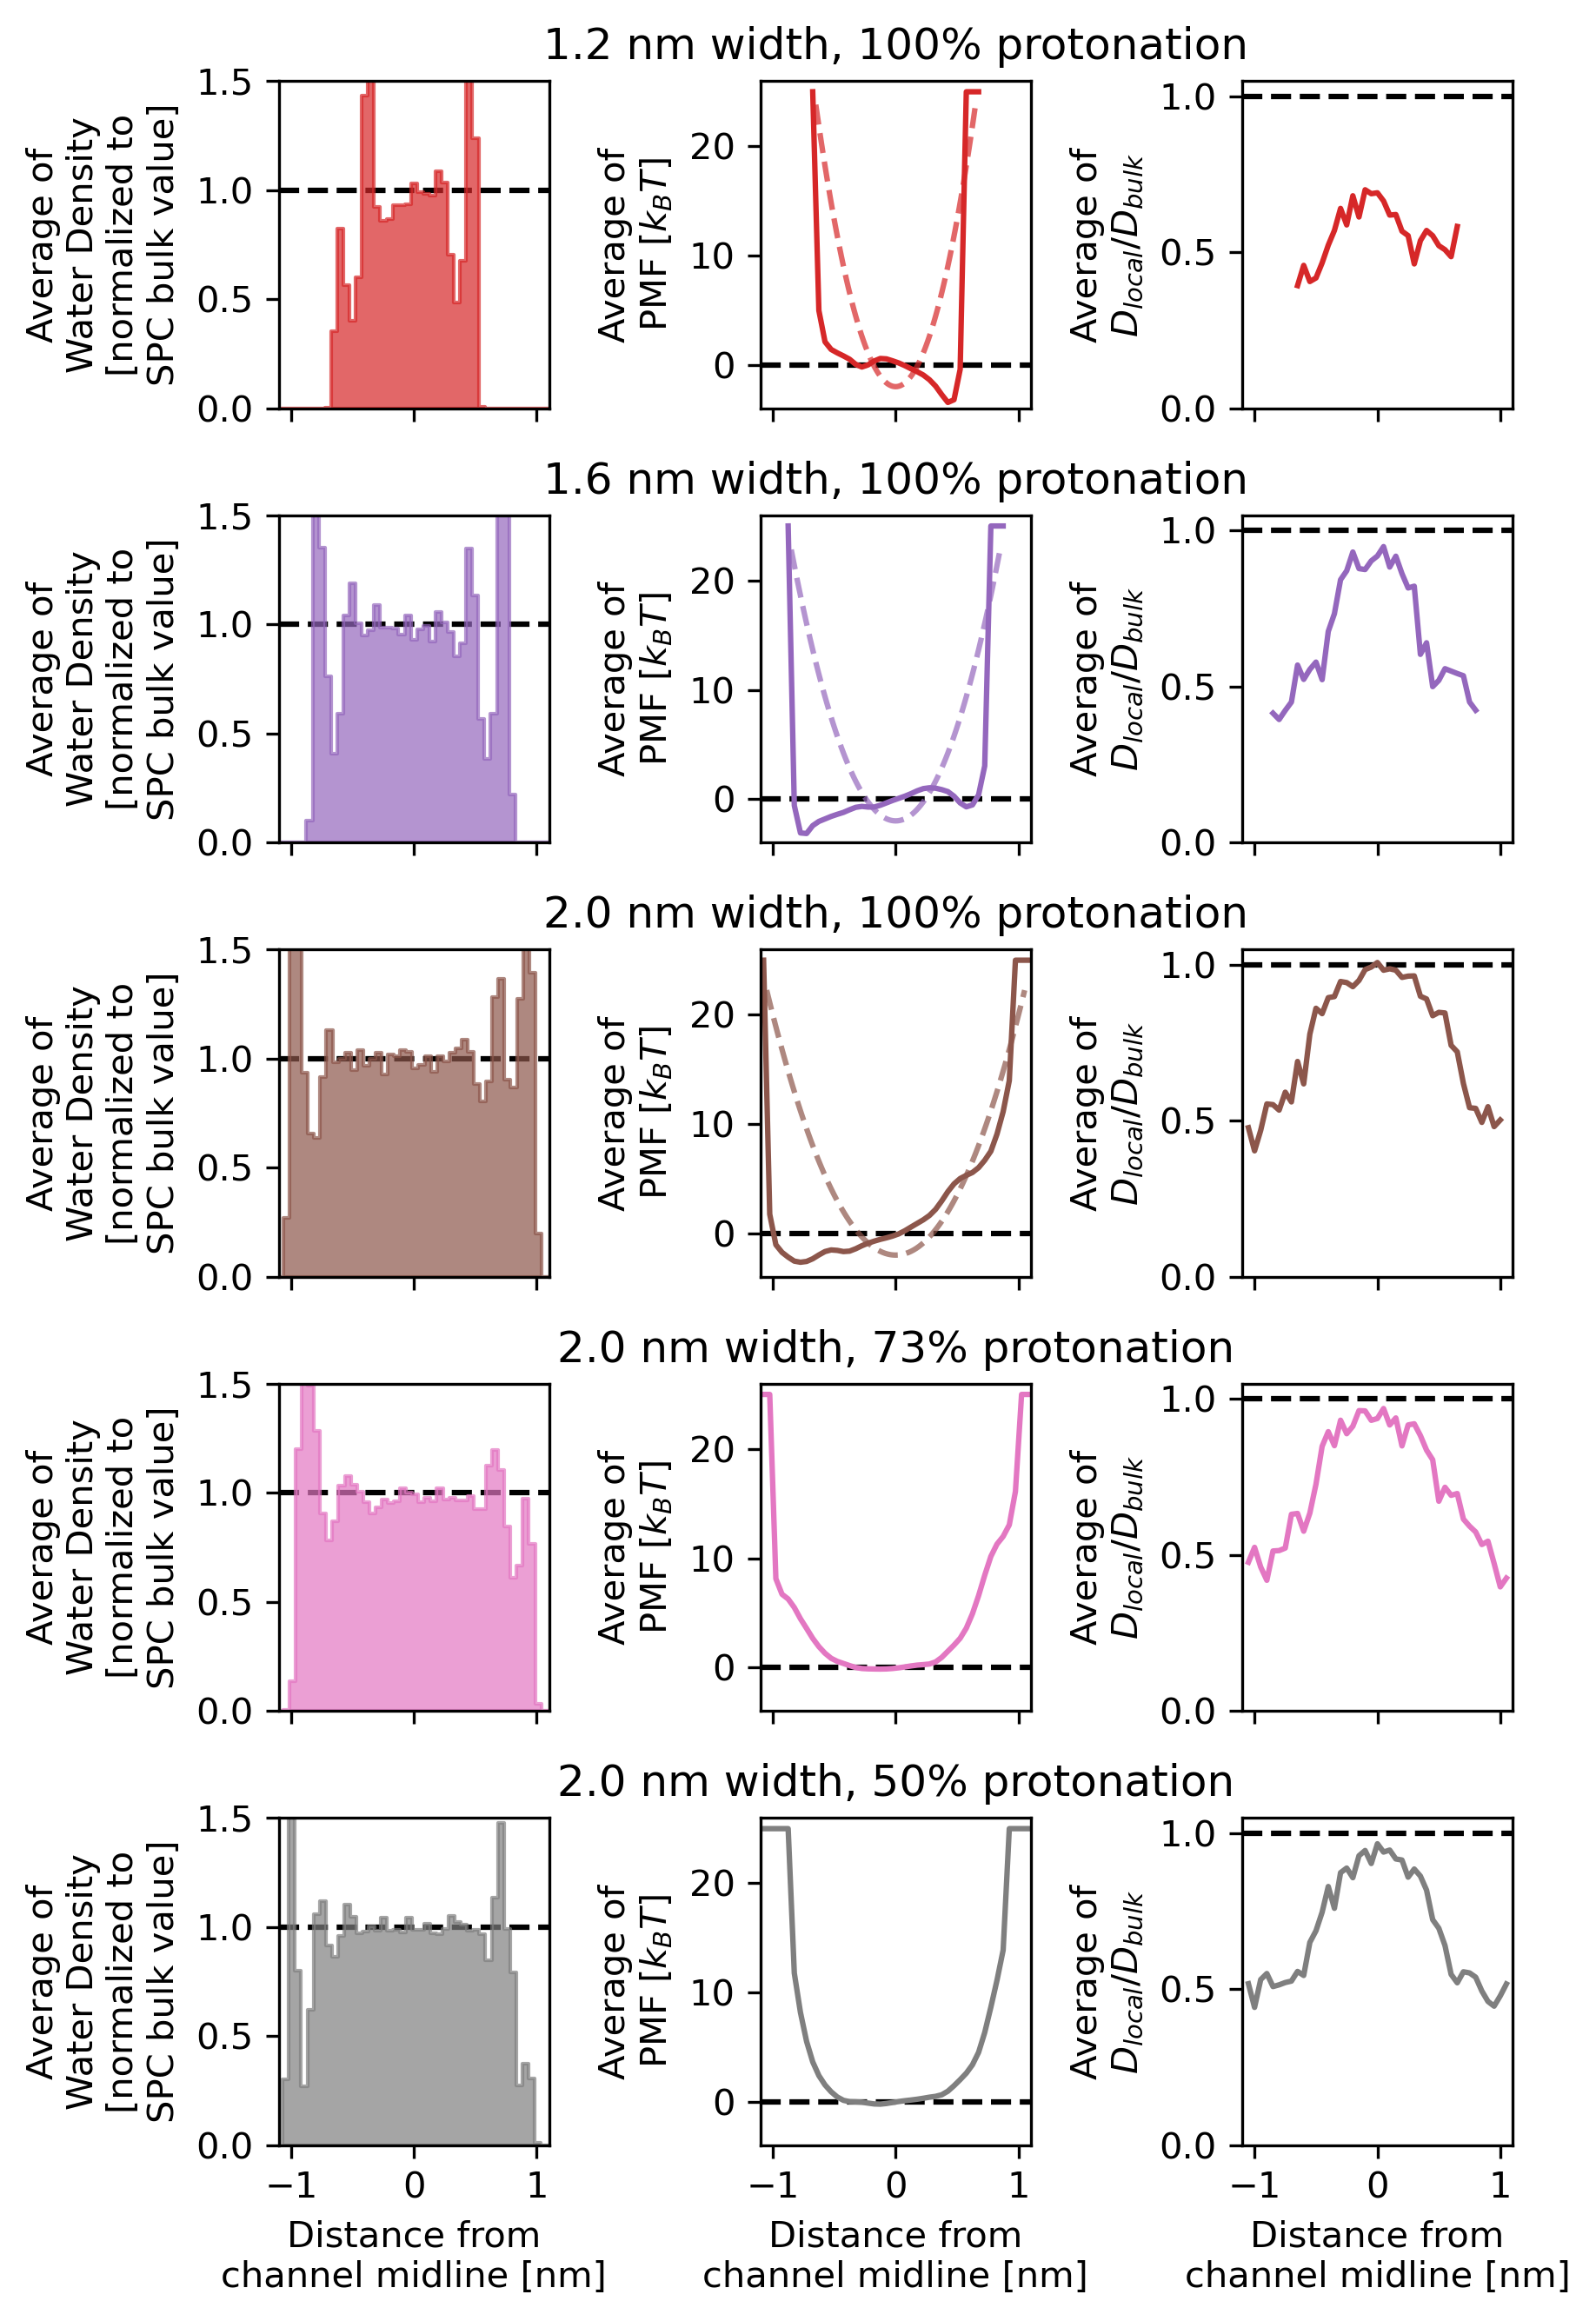

In [93]:
fig,axlist=plt.subplots(5,3,figsize=(6,9))

#Each row is a different channel
for tagdx,tag in enumerate(taglist):
  #Water density
  ax=axlist[tagdx][0]
  wdens_xvals,wdens_yvals=wdens_avg_dict[tag]
  o=ax.fill_between(wdens_xvals-Zmid_dict[tag],wdens_yvals,
                    label=series_labels[tag],color=tag_colors[tag],alpha=0.7,zorder=2)
  o=ax.plot([-1.1,1.1],[1.0,1.0],"k--",label="Bulk Condition",zorder=0)
  o=ax.set_xlim(*x_lims)
#   o=ax.xaxis.set_major_locator(loc)
  o=ax.set_ylim(*wdens_lims)
  o=ax.set_ylabel("Average of\nWater Density\n[normalized to\nSPC bulk value]")
  if tagdx == maxdx:
    o=ax.set_xlabel("Distance from\nchannel midline [nm]")
  else:
    o=ax.tick_params(labelbottom=False)
  #PMF curves
  ax=axlist[tagdx][1]
  pmf_avg=pmf_avg_dict[tag]
  o=ax.plot(pmf_avg["zhat"],pmf_avg["zeroed_PMF"],label=series_labels[tag],color=tag_colors[tag])
  if tag in quadratic_values.keys():
    zvals,psivals=quadratic_values[tag]
    o=ax.plot(zvals,psivals,"--",label="quadratic",color=tag_colors[tag],alpha=0.7)
  o=ax.plot([-1.1,1.1],[0.0,0.0],"k--",label="Bulk Condition",zorder=0)
  o=ax.set_xlim(*x_lims)
#   o=ax.xaxis.set_major_locator(loc)
  o=ax.set_ylim(*pmf_lims)
  o=ax.set_ylabel("Average of\nPMF [$k_BT$]")
  if tagdx == maxdx:
    o=ax.set_xlabel("Distance from\nchannel midline [nm]")
  else:
    o=ax.tick_params(labelbottom=False)
  #Title goes over the middle graph
  o=ax.set_title(series_labels[tag])
  #Dlocal curves
  ax=axlist[tagdx][2]
  dloc=dloc_avg_dict[tag]
  o=ax.plot(dloc["zhat"],dloc["Davg"],label=series_labels[tag],color=tag_colors[tag])
  o=ax.plot([-1.1,1.1],[1.0,1.0],"k--",label="Bulk Condition",zorder=0)
  o=ax.set_xlim(*x_lims)
#   o=ax.xaxis.set_major_locator(loc)
  o=ax.set_ylim(*dloc_lims)
  o=ax.set_ylabel("Average of\n$D_{local}/D_{bulk}$")
  if tagdx == maxdx:
    o=ax.set_xlabel("Distance from\nchannel midline [nm]")
  else:
    o=ax.tick_params(labelbottom=False)

#Done
fig.tight_layout()
plot_fpath=osp.join(outdir,"supp_multiplot.png")
fig.savefig(plot_fpath,dpi=300)

Draft caption:

Water density, PMF, and local diffusion coefficients for all 5 combinations of channel width and deprotonation level investigated in the MD simulations.
Values are averaged over the available data in the $y$-direction.
Bulk values are shown as black dashed lines.
The quadratic potentials used for the validation described in Section **??** are shown on the PMF plots where applicable, as dashed lines with the same color as the PMF data from MD.